**Recommendation System for Dodo Pizza**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from datetime import datetime, timedelta
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import time
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import mean_squared_error, roc_auc_score


from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Загрузка данных

In [2]:
clients_promo_october = pd.read_csv('clients_promo_october.csv')
mobile_events = pd.read_csv('mobile_events.csv')
orders = pd.read_csv('orders.csv')
submit = pd.read_csv('submit.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train_target.csv')

# Ознакомление с данными

## Промо выданные за октябрь

In [3]:
clients_promo_october.head()

,ClientUUId,Id,LocalBeginDate,LocalEndDate,OrderType,OrderPrice,Discount
0,000D3A20F23EA95811E7B7104AC23CD3,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,25
1,000D3A20F23EA95811E7B7D79FAABAA1,5,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,300
2,000D3A20F23EA95811E7B8BD71C73877,7,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1249,200
3,000D3A20F23EA95811E7B99F3ED09FC8,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1249,30
4,000D3A20F23EA95811E7BD373E79565E,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,20


In [4]:
clients_promo_october.shape

(477275, 7)

In [5]:
clients_promo_october.describe()

,Id,OrderPrice,Discount
count,477275.000000,477275.000000,477275.000000
mean,5.888025,1018.785134,127.781499
std,0.720273,242.192403,105.889668
min,5.000000,599.000000,10.000000
25%,5.000000,799.000000,20.000000
50%,6.000000,999.000000,150.000000
75%,6.000000,1249.000000,200.000000
max,7.000000,1399.000000,300.000000


In [6]:
clients_promo_october.describe(include=['O'])

,ClientUUId,LocalBeginDate,LocalEndDate,OrderType
count,477275,477275,477275,477275
unique,30000,9,9,2
top,000D3A24D2B7A94311E8C7AF4F6F7ACA,2023-10-30T00:00:00.000Z,2023-11-01T23:59:00.000Z,"1,2,3"
freq,18,55123,55123,239308


In [7]:
clients_promo_october.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477275 entries, 0 to 477274
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ClientUUId      477275 non-null  object
 1   Id              477275 non-null  int64 
 2   LocalBeginDate  477275 non-null  object
 3   LocalEndDate    477275 non-null  object
 4   OrderType       477275 non-null  object
 5   OrderPrice      477275 non-null  int64 
 6   Discount        477275 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 25.5+ MB


In [8]:
clients_promo_october.duplicated().sum()

0

## Мобильные ивенты за октябрь

In [9]:
mobile_events.head()

,ClientUUId,VisitToken,EventName,Platform,Timestamp
0,000D3A22FA54A81611EB315CF5443815,976627AD-76DC-41D9-981E-F2A6CA14B3A9,screen_menu,ios,2023-10-29T16:14:21.343Z
1,2A4A64AF719E994511EE3F2D8B31E188,5b22e610-c71e-4b6a-a842-71e8575ece87,screen_menu,android,2023-10-29T11:04:36.4840000Z
2,000D3AAC977BBB2F11ECDD081F5481AE,BDCEB72F-2B6A-4565-801A-6CB729279C6F,open_app,ios,2023-10-29T11:14:34.723Z
3,000D3A21DA51A81411EAE468856F96F1,A66E2DA6-4E2E-4C37-9FBF-627732623212,add_to_cart,ios,2023-10-29T14:03:08.363Z
4,000D3A23B0DC80D811E67F4D0A9CA345,1BE8139F-A3D3-439F-A51B-5CBD4D3FFF1B,screen_menu,ios,2023-10-29T08:35:40.127Z


In [10]:
mobile_events['EventName'].unique()

array(['screen_menu', 'open_app', 'add_to_cart', 'close_app',
       'create_order', 'screen_profile', 'screen_cart',
       'open_product_card', 'apply_personal_offer', 'remove_from_cart',
       'open_bonusaction'], dtype=object)

In [11]:
mobile_events['Platform'].unique()

array(['ios', 'android'], dtype=object)

In [12]:
mobile_events.shape

(3916654, 5)

In [13]:
mobile_events.describe()

,ClientUUId,VisitToken,EventName,Platform,Timestamp
count,3916654,3916654,3916654,3916654,3916654
unique,29838,223964,11,2,3912656
top,000D3A284715A95511E81811EF62AD07,108ACB83-BA5B-4123-987E-1D8E0D99B211,screen_menu,ios,2023-10-16T03:43:13.652Z
freq,2257,441,939487,2003021,4


In [14]:
mobile_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3916654 entries, 0 to 3916653
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   ClientUUId  object
 1   VisitToken  object
 2   EventName   object
 3   Platform    object
 4   Timestamp   object
dtypes: object(5)
memory usage: 149.4+ MB


In [15]:
mobile_events.isna().sum()

ClientUUId    0
VisitToken    0
EventName     0
Platform      0
Timestamp     0
dtype: int64

In [16]:
mobile_events.duplicated().sum()

1034

In [17]:
mobile_events.drop_duplicates(inplace=True)

## Заказы клиентов (10 последних)

In [18]:
orders.sample(5)

,OrderUUId,addressId,deliverySectorId,ClientUUId,Date,SaleDate,UnitUUId,NewClient,ClientOrderNumber,ProductUUId,CategoryId,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo
121441,EECC54B4FB40B1B611EE26F0E61C5461,0.0,0.0,62D659298E67BC9E11ED61A2BB898873,2023-07-20,2023-07-20T18:36:57.000Z,000D3ABF84C3BB2E11EBFB7F4445829D,0,12,000D3A240C71BE9A11E719BE2AB1E910,1,629.00,629.0,4,0,1219.0,1,0
211836,C2C5743080128FC711EE5891133448E1,0.0,0.0,000D3A2715C5A94E11E7C1EFCE07B5A5,2023-09-21,2023-09-21T20:32:11.000Z,000D3A240C719A8711E68ABA13F92AF4,0,55,000D3A240C71BE9A11E719BE2AB264A6,4,1.00,45.0,4,2,720.0,1,0
438925,B6B2EF1E2D7F8E5811EE1D76DC916880,0.0,0.0,000D3A26B5B080E111E77398B7D1FF51,2023-07-08,2023-07-08T17:14:35.000Z,000D3A22FA54A81411EA1CC467642722,0,107,11ED6483A53179CA40748D4E1ADF2B40,6,128.75,249.0,4,2,1310.0,1,1
70857,A6CB1BEC46DC89A411EDEC0B9C9D956A,0.0,0.0,000D3A21DA51A81211EA1F475FAAA224,2023-05-06,2023-05-06T18:03:26.000Z,000D3A21DA51A81611EB4854D4FD0747,0,19,000D3A240C71BE9A11E719BE2AB2555C,1,639.00,639.0,4,2,639.0,1,0
139709,EA34B1F76306B7F811EE219458C50DBB,0.0,0.0,000D3A29FF6BA94311E893E4E826EA2A,2023-07-13,2023-07-13T19:21:07.000Z,000D3A29FF6BA94B11E8F8724C1192BB,0,18,000D3A240C71BE9A11E719BE2AB2D427,3,135.23,169.0,4,1,1986.0,1,1


In [19]:
orders['Date'] = pd.to_datetime(orders['Date'], format='%Y.%m.%dT%H:%M:%S')
orders['SaleDate'] = pd.to_datetime(orders['SaleDate'], format='%Y.%m.%dT%H:%M:%S')

In [20]:
orders['day_of_week'] = pd.DatetimeIndex(orders['SaleDate']).day_of_week
orders['month'] = pd.DatetimeIndex(orders['SaleDate']).month

In [21]:
orders.groupby(['month'], as_index=False)['apply_promo'].mean()

,month,apply_promo
0,3,0.009450
1,4,0.073753
2,5,0.137498
3,6,0.188004
4,7,0.216957
5,8,0.213319
6,9,0.187363
7,10,0.195946


In [22]:
orders.groupby(['day_of_week'], as_index=False)['apply_promo'].mean()

,day_of_week,apply_promo
0,0,0.167169
1,1,0.178194
2,2,0.176804
3,3,0.172933
4,4,0.206395
5,5,0.200244
6,6,0.195102


In [23]:
orders.shape

(611739, 20)

In [24]:
orders.describe()

,addressId,deliverySectorId,NewClient,ClientOrderNumber,CategoryId,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo,day_of_week,month
count,4.883250e+05,488325.000000,611739.000000,611739.000000,611739.000000,611739.000000,611739.000000,611739.000000,611739.000000,611739.000000,611739.000000,611739.000000,611739.000000,611739.000000
mean,2.964650e+05,81.843000,0.000656,51.259145,2.938350,232.922882,284.286601,4.095296,1.829803,1150.672311,1.402284,0.187686,3.299600,8.045778
std,1.970507e+06,588.142806,0.025595,49.811780,1.713509,234.839101,257.768164,0.811165,0.530010,2040.545692,0.800804,0.390462,1.983166,1.833951
min,0.000000e+00,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000
25%,0.000000e+00,0.000000,0.000000,21.000000,1.000000,36.000000,109.000000,4.000000,2.000000,661.000000,1.000000,0.000000,2.000000,7.000000
50%,0.000000e+00,0.000000,0.000000,38.000000,3.000000,169.000000,199.000000,4.000000,2.000000,959.000000,1.000000,0.000000,4.000000,8.000000
75%,0.000000e+00,0.000000,0.000000,65.000000,4.000000,359.000000,419.000000,4.000000,2.000000,1344.000000,1.000000,0.000000,5.000000,10.000000
max,1.809518e+07,6798.000000,1.000000,1845.000000,7.000000,1999.000000,2199.000000,11.000000,2.000000,99418.000000,3.000000,1.000000,6.000000,10.000000


In [25]:
orders.describe(include=['O'])

,OrderUUId,ClientUUId,UnitUUId,ProductUUId
count,611739,611739,611739,611739
unique,157621,16337,784,507
top,62210C023E3B99CA11EE3201C4E65FA8,000D3A21DA51A81611EB4E0BBB1BA26D,000D3A240C719A8711E68ABA13F860BF,000D3A240C71BE9A11E719BE2AB2D427
freq,220,244,3628,38059


In [26]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611739 entries, 0 to 611738
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   OrderUUId          611739 non-null  object             
 1   addressId          488325 non-null  float64            
 2   deliverySectorId   488325 non-null  float64            
 3   ClientUUId         611739 non-null  object             
 4   Date               611739 non-null  datetime64[ns]     
 5   SaleDate           611739 non-null  datetime64[ns, UTC]
 6   UnitUUId           611739 non-null  object             
 7   NewClient          611739 non-null  int64              
 8   ClientOrderNumber  611739 non-null  int64              
 9   ProductUUId        611739 non-null  object             
 10  CategoryId         611739 non-null  int64              
 11  ProductTotalPrice  611739 non-null  float64            
 12  MenuPrice          611739 non-

In [27]:
mobile_events.duplicated().sum()

0

# EDA + feature engineering

## Промо выданные за октябрь

In [28]:
clients_promo_october.head()

,ClientUUId,Id,LocalBeginDate,LocalEndDate,OrderType,OrderPrice,Discount
0,000D3A20F23EA95811E7B7104AC23CD3,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,25
1,000D3A20F23EA95811E7B7D79FAABAA1,5,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,300
2,000D3A20F23EA95811E7B8BD71C73877,7,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1249,200
3,000D3A20F23EA95811E7B99F3ED09FC8,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1249,30
4,000D3A20F23EA95811E7BD373E79565E,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,20


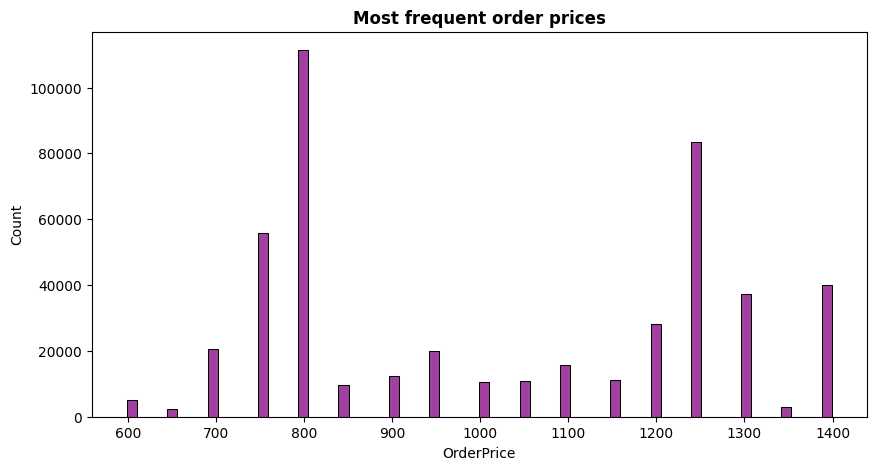

In [29]:
plt.figure(figsize=(10,5))
sns.histplot(clients_promo_october['OrderPrice'],kde=False, color=['Purple'])
plt.title('Most frequent order prices',fontweight="bold")
plt.show()

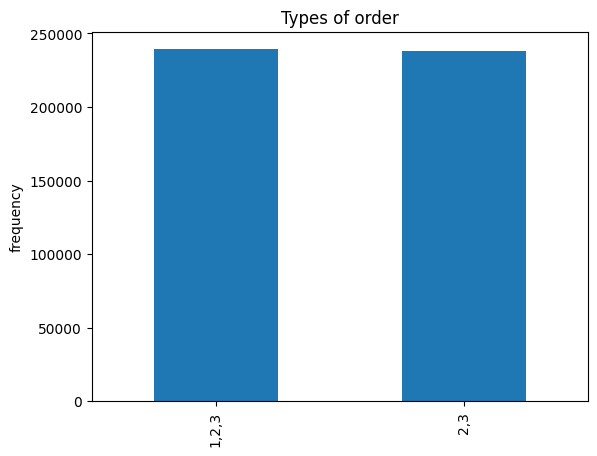

In [30]:
order_types = clients_promo_october.OrderType.value_counts()
order_types.plot(kind='bar', title='Types of order', ylabel='frequency');

In [31]:
def process_date(date_str):
    date_obj = datetime.fromisoformat(date_str.replace("Z", "+00:00"))
    rounded_date_obj = date_obj.replace(hour=0, minute=0, second=0, microsecond=0)
    if date_obj.hour >= 23:
        rounded_date_obj += timedelta(days=1)
    return rounded_date_obj

In [32]:
clients_promo_october['LocalEndDate'] = clients_promo_october['LocalEndDate'].apply(process_date)
clients_promo_october['LocalBeginDate'] = clients_promo_october['LocalBeginDate'].apply(process_date)

In [33]:
clients_promo_october['promo_duration'] = (clients_promo_october['LocalEndDate'] - clients_promo_october['LocalBeginDate']).dt.days

In [34]:
clients_promo_october['campaign_start_day'] = clients_promo_october['LocalBeginDate'].dt.day
clients_promo_october['campaign_end_day'] = clients_promo_october['LocalEndDate'].dt.day

clients_promo_october['campaign_start_weekday'] = clients_promo_october['LocalBeginDate'].dt.weekday
clients_promo_october['campaign_end_day_weekday'] = clients_promo_october['LocalEndDate'].dt.weekday

In [35]:
clients_promo_october.groupby('Id')['OrderPrice'].unique()

Id
5    [1299, 1249, 1399, 1149, 999, 1349, 949, 1049,...
6    [1299, 1249, 849, 1199, 999, 1099, 1049, 949, ...
7    [1249, 1299, 949, 1399, 899, 1349, 1199, 1099,...
Name: OrderPrice, dtype: object

In [36]:
clients_promo_october['OrderType'].unique()

array(['1,2,3', '2,3'], dtype=object)

In [37]:
clients_promo_october.groupby(['ClientUUId'], as_index=False)['Discount'].sum()

,ClientUUId,Discount
0,000D3A20F23EA95811E7B699F64188B3,2360
1,000D3A20F23EA95811E7B7104AC23CD3,1510
2,000D3A20F23EA95811E7B7D79FAABAA1,4090
3,000D3A20F23EA95811E7B88F5E50100B,1915
4,000D3A20F23EA95811E7B8BD71C73877,2320
...,...,...
29995,FEE611D04A50BE1A11ED390682517C35,990
29996,FEEF35D36F3A978511EE57FC6EBC55EC,170
29997,FEEF35D36F3AA2A411EE57D13C7D60E7,1440
29998,FEEF4D137BE19C9B11ED68BADE679AA2,2075


In [38]:
clients_promo_october[clients_promo_october['ClientUUId'] == 'FEEF35D36F3A978511EE57FC6EBC55EC']

,ClientUUId,Id,LocalBeginDate,LocalEndDate,OrderType,OrderPrice,Discount,promo_duration,campaign_start_day,campaign_end_day,campaign_start_weekday,campaign_end_day_weekday
14253,FEEF35D36F3A978511EE57FC6EBC55EC,6,2023-10-12 00:00:00+00:00,2023-10-16 00:00:00+00:00,"1,2,3",1149,20,4,12,16,3,0
41027,FEEF35D36F3A978511EE57FC6EBC55EC,6,2023-10-12 00:00:00+00:00,2023-10-16 00:00:00+00:00,"2,3",699,25,4,12,16,3,0
95110,FEEF35D36F3A978511EE57FC6EBC55EC,6,2023-10-09 00:00:00+00:00,2023-10-12 00:00:00+00:00,"1,2,3",1149,20,3,9,12,0,3
120322,FEEF35D36F3A978511EE57FC6EBC55EC,6,2023-10-02 00:00:00+00:00,2023-10-05 00:00:00+00:00,"2,3",749,20,3,2,5,0,3
144526,FEEF35D36F3A978511EE57FC6EBC55EC,6,2023-10-05 00:00:00+00:00,2023-10-09 00:00:00+00:00,"1,2,3",1099,25,4,5,9,3,0
307052,FEEF35D36F3A978511EE57FC6EBC55EC,6,2023-10-09 00:00:00+00:00,2023-10-12 00:00:00+00:00,"2,3",699,25,3,9,12,0,3
386937,FEEF35D36F3A978511EE57FC6EBC55EC,6,2023-10-02 00:00:00+00:00,2023-10-05 00:00:00+00:00,"1,2,3",1099,15,3,2,5,0,3
438408,FEEF35D36F3A978511EE57FC6EBC55EC,6,2023-10-05 00:00:00+00:00,2023-10-09 00:00:00+00:00,"2,3",749,20,4,5,9,3,0


In [39]:
promo_data = clients_promo_october.groupby('ClientUUId', as_index=False)['OrderType'].count()
promo_data = promo_data.rename(columns={'OrderType':'total_promo_given'})

In [40]:
id_discount = clients_promo_october.groupby(['ClientUUId', 'Id']).size().reset_index(name='Count')
id_discount = id_discount.loc[id_discount.groupby('ClientUUId')['Count'].idxmax()][['ClientUUId', 'Id']]
promo_data = pd.merge(promo_data, id_discount, on='ClientUUId')
promo_data.head()

,ClientUUId,total_promo_given,Id
0,000D3A20F23EA95811E7B699F64188B3,14,5
1,000D3A20F23EA95811E7B7104AC23CD3,14,6
2,000D3A20F23EA95811E7B7D79FAABAA1,18,5
3,000D3A20F23EA95811E7B88F5E50100B,16,6
4,000D3A20F23EA95811E7B8BD71C73877,16,5


## События в мобильном приложении

In [41]:
mobile_events.head()

,ClientUUId,VisitToken,EventName,Platform,Timestamp
0,000D3A22FA54A81611EB315CF5443815,976627AD-76DC-41D9-981E-F2A6CA14B3A9,screen_menu,ios,2023-10-29T16:14:21.343Z
1,2A4A64AF719E994511EE3F2D8B31E188,5b22e610-c71e-4b6a-a842-71e8575ece87,screen_menu,android,2023-10-29T11:04:36.4840000Z
2,000D3AAC977BBB2F11ECDD081F5481AE,BDCEB72F-2B6A-4565-801A-6CB729279C6F,open_app,ios,2023-10-29T11:14:34.723Z
3,000D3A21DA51A81411EAE468856F96F1,A66E2DA6-4E2E-4C37-9FBF-627732623212,add_to_cart,ios,2023-10-29T14:03:08.363Z
4,000D3A23B0DC80D811E67F4D0A9CA345,1BE8139F-A3D3-439F-A51B-5CBD4D3FFF1B,screen_menu,ios,2023-10-29T08:35:40.127Z


In [42]:
mobile_events['Timestamp'] = pd.to_datetime(mobile_events['Timestamp'])

In [43]:
mobile_events.loc[mobile_events['Platform'] == 'ios', 'Platform'] = 0 
mobile_events.loc[mobile_events['Platform'] == 'android', 'Platform'] = 1 

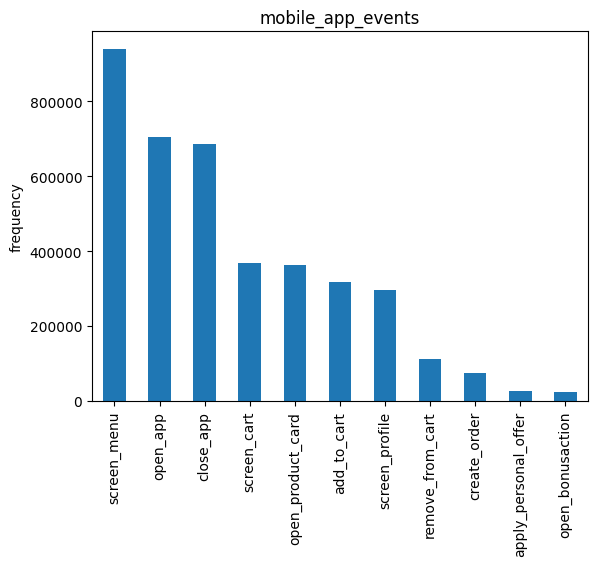

In [44]:
event_names = mobile_events.EventName.value_counts()
event_names.plot(kind='bar', title='mobile_app_events', ylabel='frequency');

In [45]:
customer_data = mobile_events.groupby('ClientUUId', as_index=False)['VisitToken'].count()

In [46]:
x = mobile_events.groupby('ClientUUId', as_index=False)['EventName'].apply(lambda x: (x == 'apply_personal_offer').sum())

In [47]:
customer_data = pd.merge(customer_data, x, on='ClientUUId')
customer_data = customer_data.rename(columns={'EventName':'total_applied_promo'})
customer_data

,ClientUUId,VisitToken,total_applied_promo
0,000D3A20F23EA95811E7B699F64188B3,169,1
1,000D3A20F23EA95811E7B7104AC23CD3,126,3
2,000D3A20F23EA95811E7B7D79FAABAA1,61,3
3,000D3A20F23EA95811E7B88F5E50100B,210,0
4,000D3A20F23EA95811E7B8BD71C73877,124,1
...,...,...,...
29833,FEE611D04A50BE1A11ED390682517C35,352,5
29834,FEEF35D36F3A978511EE57FC6EBC55EC,139,1
29835,FEEF35D36F3AA2A411EE57D13C7D60E7,316,2
29836,FEEF4D137BE19C9B11ED68BADE679AA2,97,0


In [48]:
customer_data['applied_promo_percentage'] = customer_data['total_applied_promo'] / customer_data['VisitToken']

In [49]:
mobile_events['date'] = mobile_events['Timestamp'].dt.date
unique_active_days = mobile_events.groupby('ClientUUId')['date'].nunique()

customer_data = pd.merge(customer_data, unique_active_days, on='ClientUUId')
customer_data = customer_data.rename(columns={'date':'unique_active_days'})
customer_data

,ClientUUId,VisitToken,total_applied_promo,applied_promo_percentage,unique_active_days
0,000D3A20F23EA95811E7B699F64188B3,169,1,0.005917,10
1,000D3A20F23EA95811E7B7104AC23CD3,126,3,0.023810,10
2,000D3A20F23EA95811E7B7D79FAABAA1,61,3,0.049180,2
3,000D3A20F23EA95811E7B88F5E50100B,210,0,0.000000,7
4,000D3A20F23EA95811E7B8BD71C73877,124,1,0.008065,4
...,...,...,...,...,...
29833,FEE611D04A50BE1A11ED390682517C35,352,5,0.014205,13
29834,FEEF35D36F3A978511EE57FC6EBC55EC,139,1,0.007194,7
29835,FEEF35D36F3AA2A411EE57D13C7D60E7,316,2,0.006329,8
29836,FEEF4D137BE19C9B11ED68BADE679AA2,97,0,0.000000,2


In [50]:
y = mobile_events.groupby('ClientUUId', as_index=False)['EventName'].apply(lambda x: (x == 'create_order').sum())
customer_data = pd.merge(customer_data, y, on='ClientUUId')
customer_data = customer_data.rename(columns={'EventName':'total_created_orders'})
customer_data

,ClientUUId,VisitToken,total_applied_promo,applied_promo_percentage,unique_active_days,total_created_orders
0,000D3A20F23EA95811E7B699F64188B3,169,1,0.005917,10,2
1,000D3A20F23EA95811E7B7104AC23CD3,126,3,0.023810,10,2
2,000D3A20F23EA95811E7B7D79FAABAA1,61,3,0.049180,2,2
3,000D3A20F23EA95811E7B88F5E50100B,210,0,0.000000,7,4
4,000D3A20F23EA95811E7B8BD71C73877,124,1,0.008065,4,3
...,...,...,...,...,...,...
29833,FEE611D04A50BE1A11ED390682517C35,352,5,0.014205,13,4
29834,FEEF35D36F3A978511EE57FC6EBC55EC,139,1,0.007194,7,2
29835,FEEF35D36F3AA2A411EE57D13C7D60E7,316,2,0.006329,8,2
29836,FEEF4D137BE19C9B11ED68BADE679AA2,97,0,0.000000,2,2


Text(0.5, 1.0, 'Visit tokens with the most amount of events')

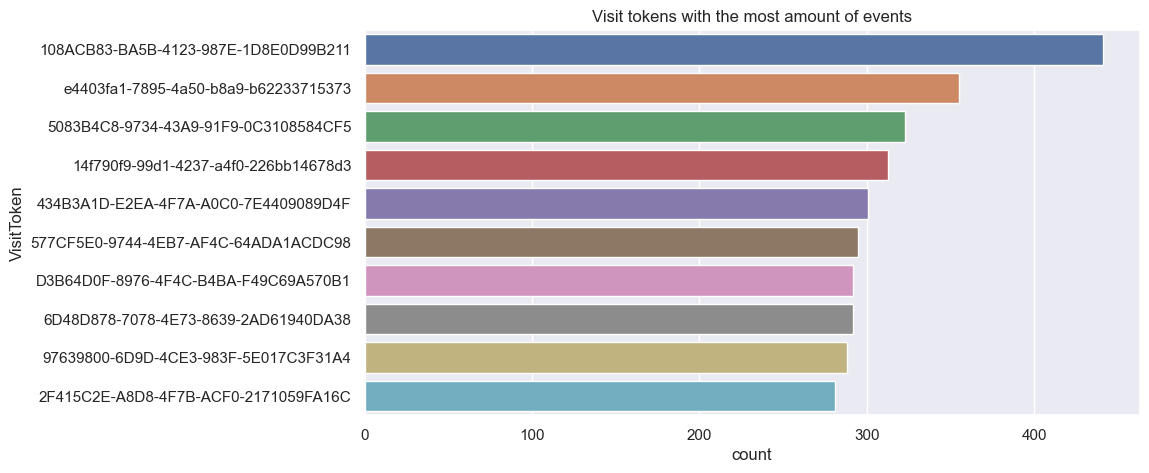

In [51]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
ax = sns.countplot(y="VisitToken", data=mobile_events, order=mobile_events['VisitToken'].value_counts().index[0:10])
plt.title('Visit tokens with the most amount of events')

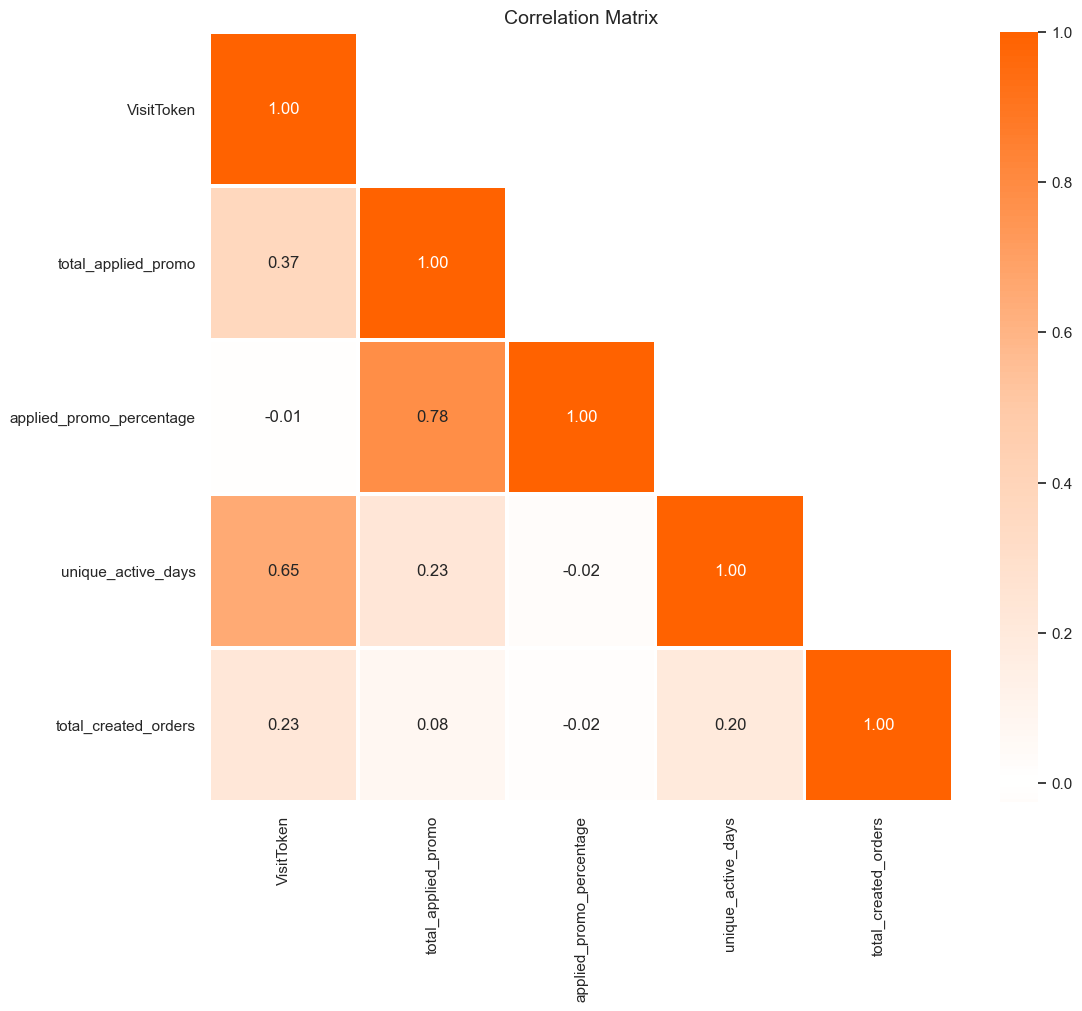

In [52]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data.drop(columns=['ClientUUId']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [53]:
customer_data = customer_data.drop(['VisitToken', 'applied_promo_percentage'], axis=1)


## Заказы клиентов

In [54]:
orders.sample(10)

,OrderUUId,addressId,deliverySectorId,ClientUUId,Date,SaleDate,UnitUUId,NewClient,ClientOrderNumber,ProductUUId,CategoryId,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo,day_of_week,month
255668,EAA66005683B8CB811EE091C9C2E253F,0.0,0.0,000D3A21DA51A81411EA7B3551F4CBC9,2023-06-12,2023-06-12 15:45:29+00:00,000D3A22FA54A81411E9BA79FD93B749,0,29,11EBADD5B90B8B4F0F2EF40F4E6B5B70,5,0.00,0.0,4,2,760.0,1,1,0,6
411751,523D3F55768DBAEF11EE1AF64BE08208,0.0,0.0,000D3A22FA54A81411E93678ABF7A99E,2023-07-05,2023-07-05 11:25:36+00:00,000D3A39D824A81011E909212C19C27C,0,37,000D3A240C71BE9A11E719BE2AB1F41E,1,319.00,319.0,4,2,638.0,1,0,2,7
592502,D6E9F42F4AFDB37D11EE60D7B47B6C01,0.0,0.0,000D3ABF84C3BB2811EB6E1389CC4346,2023-10-02,2023-10-02 11:26:23+00:00,000D3A39D824A83111EB40514830FF7B,0,30,11EC9AABAD354BE051CCF1EE21B2E4E0,1,494.00,639.0,4,2,3816.0,1,0,0,10
298194,E6C90DA8833699E711EE3B510A90C8BB,0.0,0.0,000D3A2480C380E411E734BF50C8FC02,2023-08-15,2023-08-15 13:45:40+00:00,000D3A240C719A8711E68ABA13F837F0,0,42,11ED543686D6E97413252BAB1915CE20,3,169.00,169.0,4,2,1271.0,1,0,1,8
242540,C2351B09B2C3AEB811EDCA613E3CBBA9,10728012.0,4463.0,000D3A39D824A81611E952F87BB35A10,2023-03-24,2023-03-24 20:01:55+00:00,000D3AAF2133A81111EA4CC125128F52,0,17,11EA5EE49DCBD9124A66F76490913010,1,849.00,849.0,4,2,850.0,1,0,4,3
24284,0EFE33889D798FF511EDE8BD812D70DC,0.0,0.0,000D3AAC977BBB2F11ECD9CE8A083BE9,2023-05-02,2023-05-02 12:12:43+00:00,000D3A240C719A8711E68ABA13F9491C,0,7,11EBB830B8BEDFC180C29D4BD0CF9C60,1,0.00,419.0,4,0,1249.0,1,0,1,5
365565,EAA8D0FBEEB89D8011EDEFEE592B2BD8,0.0,0.0,000D3A21DA51A81411EABC5132156913,2023-05-11,2023-05-11 17:57:46+00:00,000D3A240C719A8711E68ABA13F9C24E,0,20,11EDE68E83BF6D3A306E00850D4DF230,5,0.00,0.0,4,2,1303.0,1,0,3,5
30766,1EDF561384B79F9011EE36A7F7C4F687,NaN,NaN,000D3A39D824A83111EB3B1E3B18B563,2023-08-09,2023-08-09 14:53:14+00:00,000D3A240C719A8711E68ABA13F7FE13,0,3,000D3A24D2B7A94311E857AF49FDC657,3,120.71,169.0,4,2,625.0,3,1,2,8
292673,FEEBD2AB3613AE1611EE306707F6182F,0.0,0.0,000D3A21DA51A81311EA3CFE2C27CA6F,2023-08-01,2023-08-01 15:50:41+00:00,000D3A284715A95611E81AC56A0D7DE2,0,8,000D3A39D824A82E11E9A18231161F85,1,267.00,289.0,4,2,800.0,1,0,1,8
108368,CAC1F4A9431E99E411EE61E5FF1E85C1,0.0,0.0,1219080E2144A32D11EDCB0A98BF8732,2023-10-03,2023-10-03 20:19:23+00:00,000D3A258645A95411E81E187B5390D1,0,10,000D3A240C71BE9A11E719BE2AB2D427,3,159.00,159.0,4,1,1048.0,1,0,1,10


In [55]:
orders.groupby('OrderPaymentType', as_index=False)['apply_promo'].mean()

,OrderPaymentType,apply_promo
0,0,0.156727
1,1,0.146293
2,2,0.191494


In [56]:
orders['addressId'].fillna(0, inplace=True)
orders['deliverySectorId'].fillna(0, inplace=True)

In [57]:
orders.groupby(['ClientOrderNumber'], as_index=False)['apply_promo'].mean().sort_values('apply_promo', ascending=False)

,ClientOrderNumber,apply_promo
475,543,1.0
512,610,1.0
481,549,1.0
451,505,1.0
450,504,1.0
...,...,...
436,477,0.0
437,478,0.0
438,479,0.0
305,306,0.0


In [58]:
orders[orders['ProductUUId'] == '11EE35D9B8356918B72D6238B796C1F0']

,OrderUUId,addressId,deliverySectorId,ClientUUId,Date,SaleDate,UnitUUId,NewClient,ClientOrderNumber,ProductUUId,CategoryId,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo,day_of_week,month
194715,F64EF40FD2EF987711EE3F560A044923,0.0,0.0,000D3A229AB480CC11E6B7E04E28E524,2023-08-20,2023-08-20 17:57:21+00:00,000D3A240C719A8711E68ABA13F9993E,0,58,11EE35D9B8356918B72D6238B796C1F0,1,503.34,719.0,4,2,1146.0,1,1,6,8
481275,C23769E12F91A9CA11EE3DBC9616189F,0.0,0.0,1629044A7F759E1611ED8B4D134FFB3C,2023-08-19,2023-08-19 12:43:37+00:00,000D3A26B5B080DD11E6BBD1C5EA6748,0,15,11EE35D9B8356918B72D6238B796C1F0,1,583.61,778.0,4,2,1435.0,1,1,5,8


### Recency

**Days Since Last Purchase:** This feature represents the number of days that have passed since the customer's last purchase. A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business, whereas a higher value may indicate a lapse or decreased engagement.

In [59]:
# Find the most recent purchase date for each customer
orders_data = orders.groupby('ClientUUId')['Date'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = orders['Date'].max()

# Convert Date to datetime type before subtraction
orders_data['Date'] = pd.to_datetime(orders_data['Date'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
orders_data['Days_Since_Last_purchase'] = (most_recent_date - orders_data['Date']).dt.days

In [60]:
days_since_last_promo = orders[orders['apply_promo'] == 1]
promo_last = days_since_last_promo.groupby('ClientUUId')['Date'].max().reset_index()

# Convert Date to datetime type before subtraction
promo_last['Date'] = pd.to_datetime(promo_last['Date'])

# Calculate the number of days since the last purchase for each customer
promo_last['Days_Since_Last_promo'] = (most_recent_date - promo_last['Date']).dt.days

In [61]:
orders_data = pd.merge(orders_data, promo_last, on='ClientUUId')
orders_data = orders_data.drop(['Date_x', 'Date_y'], axis=1)
orders_data

,ClientUUId,Days_Since_Last_purchase,Days_Since_Last_promo
0,000D3A20F23EA95811E7B7104AC23CD3,8,8
1,000D3A20F23EA95811E7B88F5E50100B,0,120
2,000D3A20F23EA95811E7B8BD71C73877,10,78
3,000D3A20F23EA95811E7B95FE7E6321C,22,144
4,000D3A20F23EA95811E7B9732AA20D61,9,23
...,...,...,...
8952,FE9030CFEEE99B7611ED3DC99F919774,3,3
8953,FE9430715E40BDBA11ECF859C90ACE13,16,94
8954,FEDF5AD2CE2EA90211ED506C43F7C986,1,55
8955,FEE22A126ECA916311ECF33D671B594D,5,5


### Frequency

In this step, I am going to create two features that quantify the frequency of a customer's engagement with the brand: <br>
Total orders: This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.<br>
Total Products Purchased: This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.

In [62]:
# Calculate the total number of transactions made by each customer
total_orders = orders.groupby('ClientUUId')['ClientOrderNumber'].max().reset_index()
total_orders.rename(columns={'ClientOrderNumber': 'total_orders'}, inplace=True)


# Calculate the total number of products purchased by each customer
total_products_purchased = orders.groupby('ClientUUId')['ProductUUId'].count().reset_index()
total_products_purchased.rename(columns={'ProductUUId': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
orders_data = pd.merge(orders_data, total_orders, on='ClientUUId')
orders_data = pd.merge(orders_data, total_products_purchased, on='ClientUUId')

# Display the first few rows of the orders_data dataframe
orders_data.head()

,ClientUUId,Days_Since_Last_purchase,Days_Since_Last_promo,total_orders,Total_Products_Purchased
0,000D3A20F23EA95811E7B7104AC23CD3,8,8,151,74
1,000D3A20F23EA95811E7B88F5E50100B,0,120,66,52
2,000D3A20F23EA95811E7B8BD71C73877,10,78,121,35
3,000D3A20F23EA95811E7B95FE7E6321C,22,144,96,48
4,000D3A20F23EA95811E7B9732AA20D61,9,23,79,68


### Monetary

In this step, I am going to create two features that represent the monetary aspect of customer's transactions:

**Total Spend:** This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business. <br>
**Average Transaction Value:** This feature is calculated as the Total Spend divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.

In [63]:
# Calculate the total spend by each customer
total_order_spend = orders.groupby(['ClientUUId', 'OrderUUId'], as_index=False)['OrderTotalPrice'].max()
total_spend = total_order_spend.groupby('ClientUUId', as_index=False)['OrderTotalPrice'].sum()
total_spend.rename(columns={'OrderTotalPrice': 'total_spend'}, inplace=True)

# Calculate the average order value for each customer
average_transaction_value = total_spend.merge(total_products_purchased, on='ClientUUId')
average_transaction_value['avg_order_price'] = average_transaction_value['total_spend'] / average_transaction_value['Total_Products_Purchased']


# Merge the new features into the order_data dataframe
orders_data = pd.merge(orders_data, total_spend, on='ClientUUId')
orders_data = pd.merge(orders_data, average_transaction_value[['ClientUUId','avg_order_price']], on='ClientUUId')
orders_data.head(7)

,ClientUUId,Days_Since_Last_purchase,Days_Since_Last_promo,total_orders,Total_Products_Purchased,total_spend,avg_order_price
0,000D3A20F23EA95811E7B7104AC23CD3,8,8,151,74,11081.0,149.743243
1,000D3A20F23EA95811E7B88F5E50100B,0,120,66,52,9025.0,173.557692
2,000D3A20F23EA95811E7B8BD71C73877,10,78,121,35,8575.0,245.000000
3,000D3A20F23EA95811E7B95FE7E6321C,22,144,96,48,8353.0,174.020833
4,000D3A20F23EA95811E7B9732AA20D61,9,23,79,68,12091.0,177.808824
5,000D3A20F23EA95811E7BC9736254688,2,72,88,27,5001.0,185.222222
6,000D3A20F23EA95811E7BD5381DD0E77,8,8,21,40,8387.0,209.675000


In [64]:
menu_price = orders.groupby(['ClientUUId', 'OrderUUId'], as_index=False)['MenuPrice'].sum()
avg_menu_price = menu_price.groupby('ClientUUId', as_index=False)['MenuPrice'].mean()
avg_menu_price.rename(columns={'MenuPrice': 'avg_menu_price'}, inplace=True)
orders_data = pd.merge(orders_data, avg_menu_price, on='ClientUUId')
orders_data.head()

,ClientUUId,Days_Since_Last_purchase,Days_Since_Last_promo,total_orders,Total_Products_Purchased,total_spend,avg_order_price,avg_menu_price
0,000D3A20F23EA95811E7B7104AC23CD3,8,8,151,74,11081.0,149.743243,1488.900000
1,000D3A20F23EA95811E7B88F5E50100B,0,120,66,52,9025.0,173.557692,1115.555556
2,000D3A20F23EA95811E7B8BD71C73877,10,78,121,35,8575.0,245.000000,1058.400000
3,000D3A20F23EA95811E7B95FE7E6321C,22,144,96,48,8353.0,174.020833,1046.000000
4,000D3A20F23EA95811E7B9732AA20D61,9,23,79,68,12091.0,177.808824,1553.600000


### Product diversity

Unique Products Purchased: This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference.

In [65]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = orders.groupby('ClientUUId')['ProductUUId'].nunique().reset_index()
unique_products_purchased.rename(columns={'ProductUUId': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
orders_data = pd.merge(orders_data, unique_products_purchased, on='ClientUUId')

# Display the first few rows of the customer_data dataframe
orders_data.head()

,ClientUUId,Days_Since_Last_purchase,Days_Since_Last_promo,total_orders,Total_Products_Purchased,total_spend,avg_order_price,avg_menu_price,Unique_Products_Purchased
0,000D3A20F23EA95811E7B7104AC23CD3,8,8,151,74,11081.0,149.743243,1488.900000,21
1,000D3A20F23EA95811E7B88F5E50100B,0,120,66,52,9025.0,173.557692,1115.555556,17
2,000D3A20F23EA95811E7B8BD71C73877,10,78,121,35,8575.0,245.000000,1058.400000,25
3,000D3A20F23EA95811E7B95FE7E6321C,22,144,96,48,8353.0,174.020833,1046.000000,25
4,000D3A20F23EA95811E7B9732AA20D61,9,23,79,68,12091.0,177.808824,1553.600000,40


### Behavioral features

In this step, we aim to understand and capture the shopping patterns and behaviors of customers <br>
Average Days Between Purchases: This feature represents the average number of days a customer waits before making another purchase.<br>
Favorite Shopping Day: This denotes the day of the week when the customer shops the most. <br>



In [66]:
orders.head()

,OrderUUId,addressId,deliverySectorId,ClientUUId,Date,SaleDate,UnitUUId,NewClient,ClientOrderNumber,ProductUUId,CategoryId,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo,day_of_week,month
0,020DD76CCD949AE011EDE031ED5D76FD,0.0,0.0,000D3AAC9DCABB2E11EBE0614C89D044,2023-04-21,2023-04-21 20:51:26+00:00,000D3A2480C380DA11E692CFB9F92484,0,18,000D3A240C71BE9A11E719BE2AB264A6,4,1.0,45.0,4,2,1.0,3,0,4,4
1,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02 21:31:32+00:00,000D3A26B5B080DF11E745FD0474B95C,0,29,11EC9AABAD354BE051CCF1EE1F83A8D0,1,485.0,485.0,4,2,1164.0,1,0,0,10
2,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02 21:31:32+00:00,000D3A26B5B080DF11E745FD0474B95C,0,29,11EB846583CB3BDEA80D1A7F2E184D40,1,589.0,589.0,4,2,1164.0,1,0,0,10
3,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02 21:31:32+00:00,000D3A26B5B080DF11E745FD0474B95C,0,29,000D3A240C71BE9A11E719BE2AB267FD,4,45.0,45.0,4,2,1164.0,1,0,0,10
4,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02 21:31:32+00:00,000D3A26B5B080DF11E745FD0474B95C,0,29,000D3A240C71BE9A11E719BE2AB264A6,4,45.0,45.0,4,2,1164.0,1,0,0,10


In [67]:
# Calculate the average number of days between consecutive purchases
orders_grouped = orders.groupby(['ClientUUId', 'OrderUUId'], as_index=False)['Date'].max()
orders_grouped = orders_grouped.sort_values(by=['ClientUUId', 'Date'])

days_between_purchases = orders_grouped.groupby('ClientUUId')['Date'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('ClientUUId').mean().reset_index()
average_days_between_purchases.rename(columns={'Date': 'Average_Days_Between_Purchases'}, inplace=True)
average_days_between_purchases.head()

,ClientUUId,Average_Days_Between_Purchases
0,000D3A20F23EA95811E7B7104AC23CD3,20.444444
1,000D3A20F23EA95811E7B88F5E50100B,21.500000
2,000D3A20F23EA95811E7B8BD71C73877,9.333333
3,000D3A20F23EA95811E7B95FE7E6321C,18.555556
4,000D3A20F23EA95811E7B969B5BD2C3F,10.888889


In [68]:
orders_data = pd.merge(orders_data, average_days_between_purchases, on='ClientUUId', how='left')

### Geographical features

In [69]:
orders['Is_address'] = orders['addressId'].apply(lambda x: 0 if x == 0 else 1)
orders.head()

,OrderUUId,addressId,deliverySectorId,ClientUUId,Date,SaleDate,UnitUUId,NewClient,ClientOrderNumber,ProductUUId,...,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo,day_of_week,month,Is_address
0,020DD76CCD949AE011EDE031ED5D76FD,0.0,0.0,000D3AAC9DCABB2E11EBE0614C89D044,2023-04-21,2023-04-21 20:51:26+00:00,000D3A2480C380DA11E692CFB9F92484,0,18,000D3A240C71BE9A11E719BE2AB264A6,...,1.0,45.0,4,2,1.0,3,0,4,4,0
1,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02 21:31:32+00:00,000D3A26B5B080DF11E745FD0474B95C,0,29,11EC9AABAD354BE051CCF1EE1F83A8D0,...,485.0,485.0,4,2,1164.0,1,0,0,10,0
2,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02 21:31:32+00:00,000D3A26B5B080DF11E745FD0474B95C,0,29,11EB846583CB3BDEA80D1A7F2E184D40,...,589.0,589.0,4,2,1164.0,1,0,0,10,0
3,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02 21:31:32+00:00,000D3A26B5B080DF11E745FD0474B95C,0,29,000D3A240C71BE9A11E719BE2AB267FD,...,45.0,45.0,4,2,1164.0,1,0,0,10,0
4,02164D9B0F67BC3311EE610987AF48C7,0.0,0.0,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02 21:31:32+00:00,000D3A26B5B080DF11E745FD0474B95C,0,29,000D3A240C71BE9A11E719BE2AB264A6,...,45.0,45.0,4,2,1164.0,1,0,0,10,0


In [70]:
address = orders.groupby(['ClientUUId', 'Is_address']).size().reset_index(name='Count')
address = address.loc[address.groupby('ClientUUId')['Count'].idxmax()][['ClientUUId', 'Is_address']]
orders_data = pd.merge(orders_data, address, on='ClientUUId')
orders_data.head()

,ClientUUId,Days_Since_Last_purchase,Days_Since_Last_promo,total_orders,Total_Products_Purchased,total_spend,avg_order_price,avg_menu_price,Unique_Products_Purchased,Average_Days_Between_Purchases,Is_address
0,000D3A20F23EA95811E7B7104AC23CD3,8,8,151,74,11081.0,149.743243,1488.900000,21,20.444444,0
1,000D3A20F23EA95811E7B88F5E50100B,0,120,66,52,9025.0,173.557692,1115.555556,17,21.500000,0
2,000D3A20F23EA95811E7B8BD71C73877,10,78,121,35,8575.0,245.000000,1058.400000,25,9.333333,0
3,000D3A20F23EA95811E7B95FE7E6321C,22,144,96,48,8353.0,174.020833,1046.000000,25,18.555556,0
4,000D3A20F23EA95811E7B9732AA20D61,9,23,79,68,12091.0,177.808824,1553.600000,40,10.111111,0


## Train

In [71]:
train.head()

,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount,apply_promo
0,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0
1,000D3A20F23EA95811E7B99F3ED09FC8,6,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,25,0
2,000D3A20F23EA95811E7BD373E79565E,5,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,799,200,0
3,000D3A20F23EA95811E7BD373E79565E,5,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,250,0
4,000D3A20F23EA95811E7BDAE71CD3F33,6,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,30,0


In [72]:
train['LocalBeginDate'] = pd.to_datetime(train['LocalBeginDate'])
train['LocalEndDate'] = pd.to_datetime(train['LocalEndDate'])

In [73]:
train['OrderType'].unique()

array(['2,3', '1,2,3'], dtype=object)

In [74]:
train.loc[train['OrderType'] == '2,3', 'OrderType'] = 0 
train.loc[train['OrderType'] == '1,2,3', 'OrderType'] = 1 
train['OrderType'] = train['OrderType'].astype('int64')

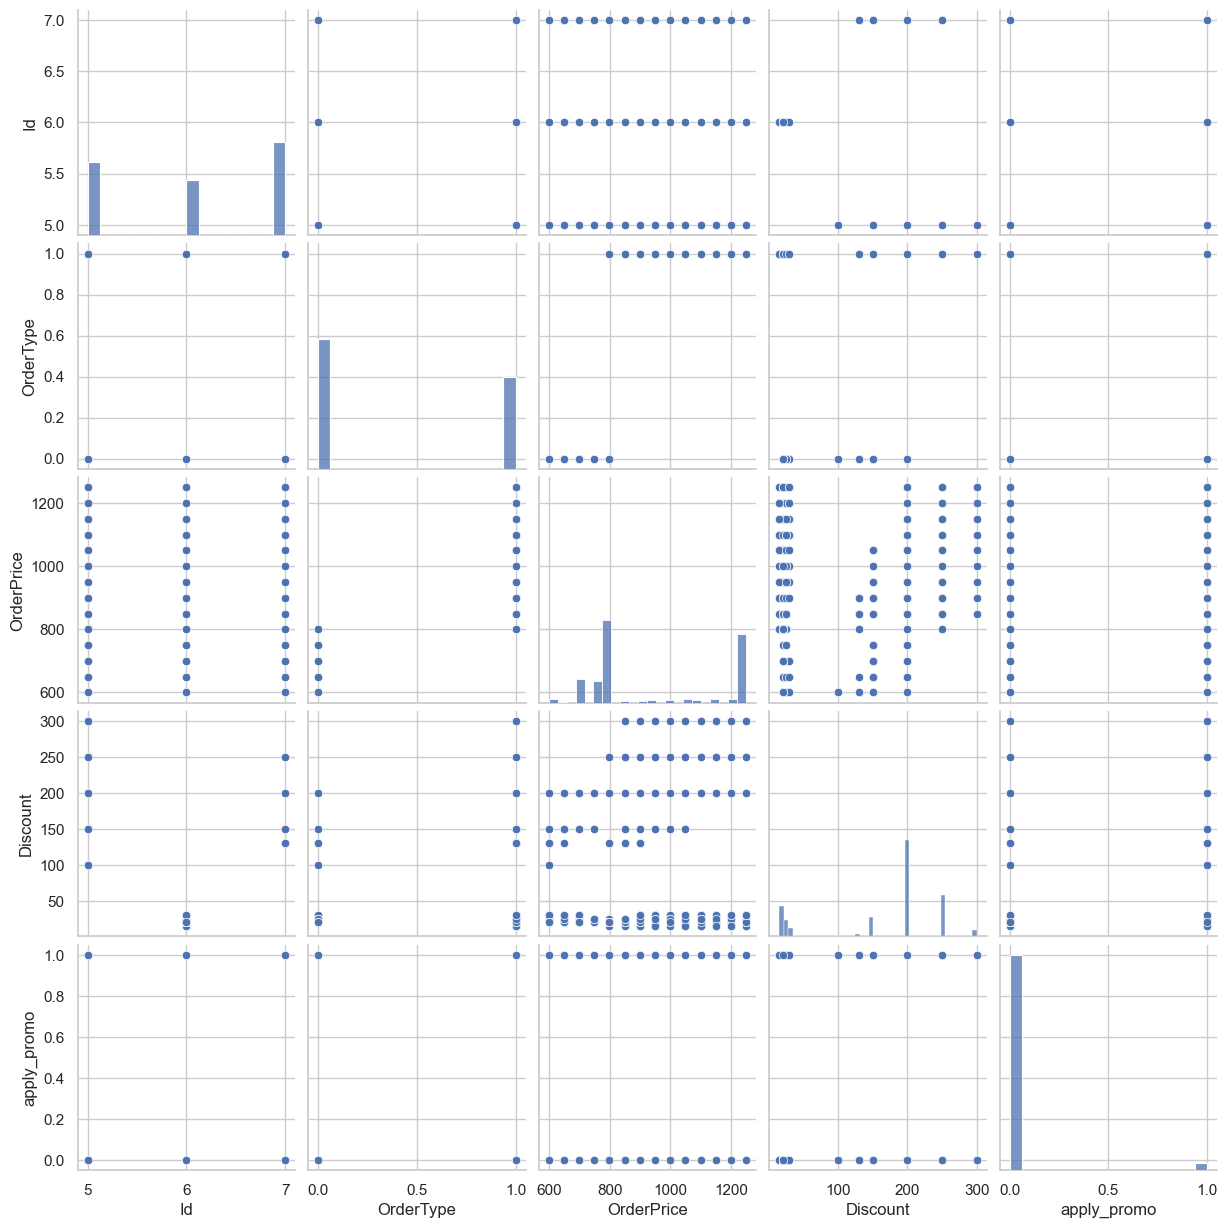

In [75]:
sns.pairplot(train)

In [76]:
def total_discount(row):
    if row['Id'] == 5:
        return row['Discount']
    elif row['Id'] == 6:
        return row['Discount'] * row['OrderPrice'] / 100
    elif row['Id'] == 7:
        return row['Discount']

In [77]:
train['total_discount'] = train.apply(total_discount, axis=1)
train

,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount,apply_promo,total_discount
0,000D3A20F23EA95811E7B99F3ED09FC8,7,0,2023-11-02 00:00:00+00:00,2023-11-05 23:59:00+00:00,699,200,0,200.00
1,000D3A20F23EA95811E7B99F3ED09FC8,6,1,2023-11-02 00:00:00+00:00,2023-11-05 23:59:00+00:00,1249,25,0,312.25
2,000D3A20F23EA95811E7BD373E79565E,5,0,2023-11-02 00:00:00+00:00,2023-11-05 23:59:00+00:00,799,200,0,200.00
3,000D3A20F23EA95811E7BD373E79565E,5,1,2023-11-02 00:00:00+00:00,2023-11-05 23:59:00+00:00,1249,250,0,250.00
4,000D3A20F23EA95811E7BDAE71CD3F33,6,0,2023-11-02 00:00:00+00:00,2023-11-05 23:59:00+00:00,699,30,0,209.70
...,...,...,...,...,...,...,...,...,...
27736,82EDBCD6CE60978F11EDC591DCA75401,5,0,2023-11-02 00:00:00+00:00,2023-11-05 23:59:00+00:00,799,200,0,200.00
27737,82EDBCD6CE60978F11EDC591DCA75401,5,1,2023-11-02 00:00:00+00:00,2023-11-05 23:59:00+00:00,1249,250,0,250.00
27738,82F78FC7401A9ADD11EDFA15A350D31F,6,0,2023-11-02 00:00:00+00:00,2023-11-05 23:59:00+00:00,799,20,0,159.80
27739,8606F5E4CA39BF7211EE517E6E1D90B7,5,0,2023-11-02 00:00:00+00:00,2023-11-05 23:59:00+00:00,749,200,0,200.00


In [78]:
train['ClientUUId'].nunique()

18598

In [79]:
train = pd.merge(train, orders_data, on='ClientUUId', how='left')

In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27741 entries, 0 to 27740
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   ClientUUId                      27741 non-null  object             
 1   Id                              27741 non-null  int64              
 2   OrderType                       27741 non-null  int64              
 3   LocalBeginDate                  27741 non-null  datetime64[ns, UTC]
 4   LocalEndDate                    27741 non-null  datetime64[ns, UTC]
 5   OrderPrice                      27741 non-null  int64              
 6   Discount                        27741 non-null  int64              
 7   apply_promo                     27741 non-null  int64              
 8   total_discount                  27741 non-null  float64            
 9   Days_Since_Last_purchase        8402 non-null   float64            
 10  Days_Since

In [81]:
train = pd.merge(train, customer_data, on='ClientUUId', how='left')

In [82]:
train = pd.merge(train, promo_data, on='ClientUUId', how='left')

In [83]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id_x,27741.0,6.089831,0.861960,5.000000,5.000000,6.000000,7.000000,7.000000
OrderType,27741.0,0.414044,0.492565,0.000000,0.000000,0.000000,1.000000,1.000000
OrderPrice,27741.0,943.219747,225.759604,599.000000,799.000000,799.000000,1249.000000,1249.000000
Discount,27741.0,162.694928,86.335719,15.000000,100.000000,200.000000,200.000000,300.000000
apply_promo,27741.0,0.029811,0.170070,0.000000,0.000000,0.000000,0.000000,1.000000
total_discount,27741.0,208.937901,48.143501,100.000000,187.250000,200.000000,250.000000,374.700000
Days_Since_Last_purchase,8402.0,7.844918,6.404666,0.000000,3.000000,6.000000,11.000000,30.000000
Days_Since_Last_promo,8402.0,39.868484,40.364551,0.000000,10.000000,25.000000,59.000000,218.000000
total_orders,8402.0,55.997620,46.643971,10.000000,26.000000,43.000000,71.000000,733.000000
Total_Products_Purchased,8402.0,39.517377,17.807318,5.000000,27.000000,36.000000,48.000000,169.000000


In [84]:
train = train.fillna(train.median(numeric_only=True))

## Test

In [85]:
test.head()

,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount
0,000D3A20F23EA95811E7C0A95563344E,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200
1,000D3A20F23EA95811E7C7892A0CE261,5,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,699,200
2,000D3A20F23EA95811E7CD686C396528,6,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,20
3,000D3A20F23EA95911E7CEA8C574EDAE,5,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200
4,000D3A20F23EA95911E7D4F05C59C978,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200


In [86]:
test['LocalBeginDate'] = pd.to_datetime(test['LocalBeginDate'])
test['LocalEndDate'] = pd.to_datetime(test['LocalEndDate'])

In [87]:
test.loc[test['OrderType'] == '2,3', 'OrderType'] = 0 
test.loc[test['OrderType'] == '1,2,3', 'OrderType'] = 1 
test['OrderType'] = test['OrderType'].astype('int64')

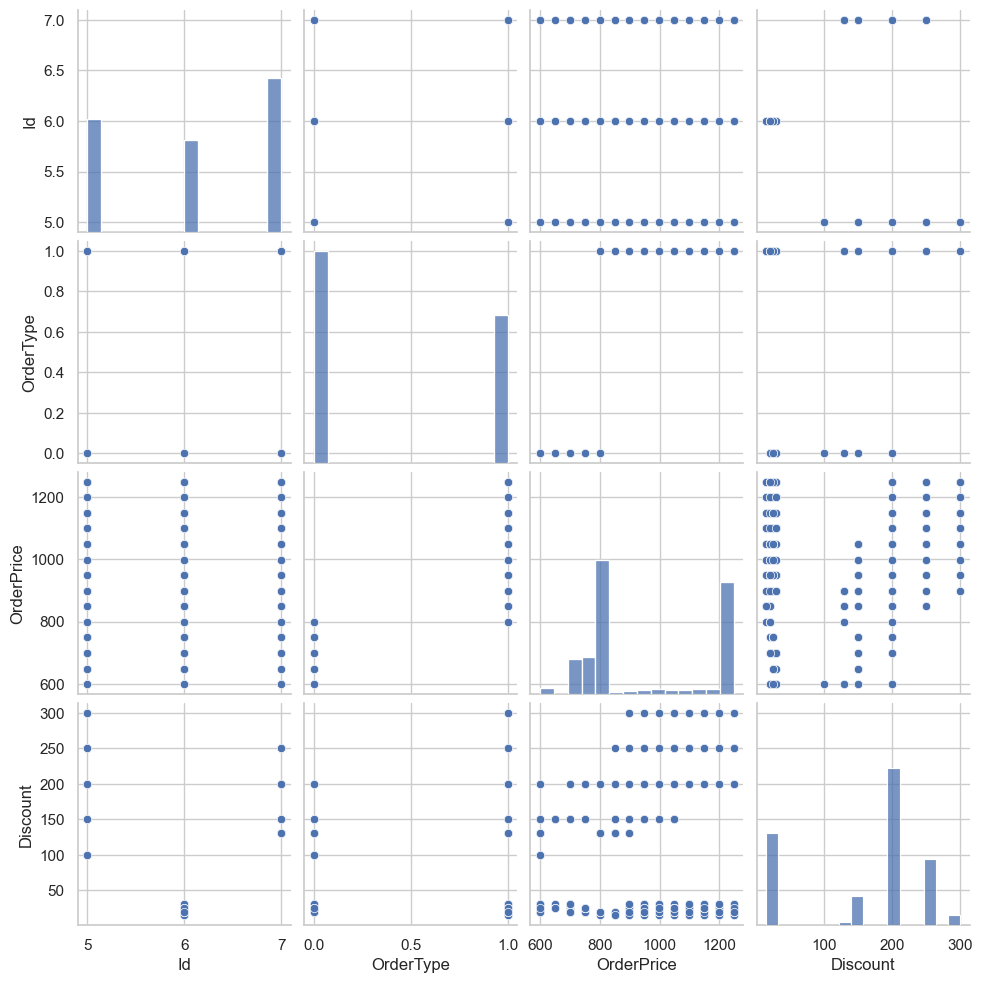

In [88]:
sns.pairplot(test)

In [89]:
test['total_discount'] = test.apply(total_discount, axis=1)

In [90]:
test = pd.merge(test, orders_data, on='ClientUUId', how='left')

In [91]:
test = pd.merge(test, customer_data, on='ClientUUId', how='left')

In [92]:
test = pd.merge(test, promo_data, on='ClientUUId', how='left')

In [93]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6806 entries, 0 to 6805
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   ClientUUId                      6806 non-null   object             
 1   Id_x                            6806 non-null   int64              
 2   OrderType                       6806 non-null   int64              
 3   LocalBeginDate                  6806 non-null   datetime64[ns, UTC]
 4   LocalEndDate                    6806 non-null   datetime64[ns, UTC]
 5   OrderPrice                      6806 non-null   int64              
 6   Discount                        6806 non-null   int64              
 7   total_discount                  6806 non-null   float64            
 8   Days_Since_Last_purchase        2065 non-null   float64            
 9   Days_Since_Last_promo           2065 non-null   float64            
 10  total_orders

In [94]:
train = train.fillna(train.median(numeric_only=True))

In [95]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6806 entries, 0 to 6805
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   ClientUUId                      6806 non-null   object             
 1   Id_x                            6806 non-null   int64              
 2   OrderType                       6806 non-null   int64              
 3   LocalBeginDate                  6806 non-null   datetime64[ns, UTC]
 4   LocalEndDate                    6806 non-null   datetime64[ns, UTC]
 5   OrderPrice                      6806 non-null   int64              
 6   Discount                        6806 non-null   int64              
 7   total_discount                  6806 non-null   float64            
 8   Days_Since_Last_purchase        2065 non-null   float64            
 9   Days_Since_Last_promo           2065 non-null   float64            
 10  total_orders

# Pipeline creating

In [96]:
features = train.drop(['ClientUUId', 'apply_promo', 'LocalBeginDate', 'LocalEndDate'], axis=1)
target = train['apply_promo']
test = test.drop(['ClientUUId', 'LocalBeginDate', 'LocalEndDate'], axis=1)

In [97]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=123)

# Model building

## RandomForest

In [98]:
rfc = RandomForestClassifier()

In [99]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'min_samples_split': [5, 10],
    'max_depth': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['entropy'],
}

In [100]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')

In [101]:
CV_rfc.fit(features_train, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': [2, 4, 6, 8],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='roc_auc')

In [102]:
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 150}
0.7961302268147673


## NaiveBayes

In [103]:
gnb = GaussianNB()

In [104]:
param_grid = {
    'var_smoothing': [0.00000001, 0.000000001, 0.0000000001],
}

In [105]:
CV_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')

In [106]:
CV_gnb.fit(features_train, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-08, 1e-09, 1e-10]},
             scoring='roc_auc')

In [107]:
print(CV_gnb.best_params_)
print(CV_gnb.best_score_)

{'var_smoothing': 1e-08}
0.7165780258927521


## LightGBM

In [108]:
lgb = LGBMClassifier()

In [109]:
params_grid_lgb = {"max_depth": [5],
              "learning_rate" : [0.1,0.3],
              "num_leaves": [50,100],
              "n_estimators": [100,150],
              'is_unbalance': [True],
              'boost_from_average': [False],
              'device': ['gpu'],
              'gpu_platform_id': [0],
              'gpu_device_id': [0],
              "random_state": [2]
}

In [110]:
CV_lgb = GridSearchCV(estimator=lgb, param_grid=params_grid_lgb, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')

In [111]:
CV_lgb.fit(features_train, target_train)

[LightGBM] [Info] Number of positive: 529, number of negative: 17224
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1723
[LightGBM] [Info] Number of data points in the train set: 17753, number of used features: 19
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.27 MB) transferred to GPU in 0.001292 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LGBMClassifier(),
             param_grid={'boost_from_average': [False], 'device': ['gpu'],
                         'gpu_device_id': [0], 'gpu_platform_id': [0],
                         'is_unbalance': [True], 'learning_rate': [0.1, 0.3],
                         'max_depth': [5], 'n_estimators': [100, 150],
                         'num_leaves': [50, 100], 'random_state': [2]},
             scoring='roc_auc')

In [112]:
print(CV_lgb.best_params_)
print(CV_lgb.best_score_)

{'boost_from_average': False, 'device': 'gpu', 'gpu_device_id': 0, 'gpu_platform_id': 0, 'is_unbalance': True, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 100, 'random_state': 2}
0.7682097587633315


## XGBoost

In [113]:
xgb = XGBClassifier()

In [114]:
params_grid_xgb = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [115]:
CV_xgb = GridSearchCV(estimator=xgb, param_grid=params_grid_xgb, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')

In [116]:
CV_xgb.fit(features_train, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc')

In [117]:
print(CV_xgb.best_params_)
print(CV_xgb.best_score_)

{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 1.0}
0.7901170266162809


## Catboost

In [118]:
cat = CatBoostClassifier()

In [119]:
params_grid_cat = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 6]
}

In [120]:
CV_cat = GridSearchCV(estimator=cat, param_grid=params_grid_cat, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')

In [121]:
CV_cat.fit(features_train, target_train)

0:	learn: 0.6763977	total: 143ms	remaining: 14.2s
1:	learn: 0.6602541	total: 146ms	remaining: 7.17s
2:	learn: 0.6447002	total: 150ms	remaining: 4.84s
3:	learn: 0.6297363	total: 153ms	remaining: 3.66s
4:	learn: 0.6153026	total: 156ms	remaining: 2.96s
5:	learn: 0.6008161	total: 159ms	remaining: 2.49s
6:	learn: 0.5868849	total: 162ms	remaining: 2.15s
7:	learn: 0.5729563	total: 165ms	remaining: 1.9s
8:	learn: 0.5601350	total: 168ms	remaining: 1.7s
9:	learn: 0.5474626	total: 172ms	remaining: 1.54s
10:	learn: 0.5354035	total: 175ms	remaining: 1.41s
11:	learn: 0.5234896	total: 177ms	remaining: 1.3s
12:	learn: 0.5117668	total: 180ms	remaining: 1.21s
13:	learn: 0.5007465	total: 184ms	remaining: 1.13s
14:	learn: 0.4897022	total: 187ms	remaining: 1.06s
15:	learn: 0.4792216	total: 191ms	remaining: 1s
16:	learn: 0.4685369	total: 194ms	remaining: 945ms
17:	learn: 0.4587652	total: 197ms	remaining: 896ms
18:	learn: 0.4493600	total: 200ms	remaining: 851ms
19:	learn: 0.4402349	total: 202ms	remaining: 81

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=<catboost.core.CatBoostClassifier object at 0x0000020F08D01B50>,
             param_grid={'depth': [3, 6], 'iterations': [100, 200],
                         'learning_rate': [0.01, 0.1]},
             scoring='roc_auc')

In [122]:
print(CV_cat.best_params_)
print(CV_cat.best_score_)

{'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
0.7867864794041853


# Features importance

In [123]:
model = CV_xgb.best_estimator_

 95%|=================== | 20976/22192 [00:12<00:00]       

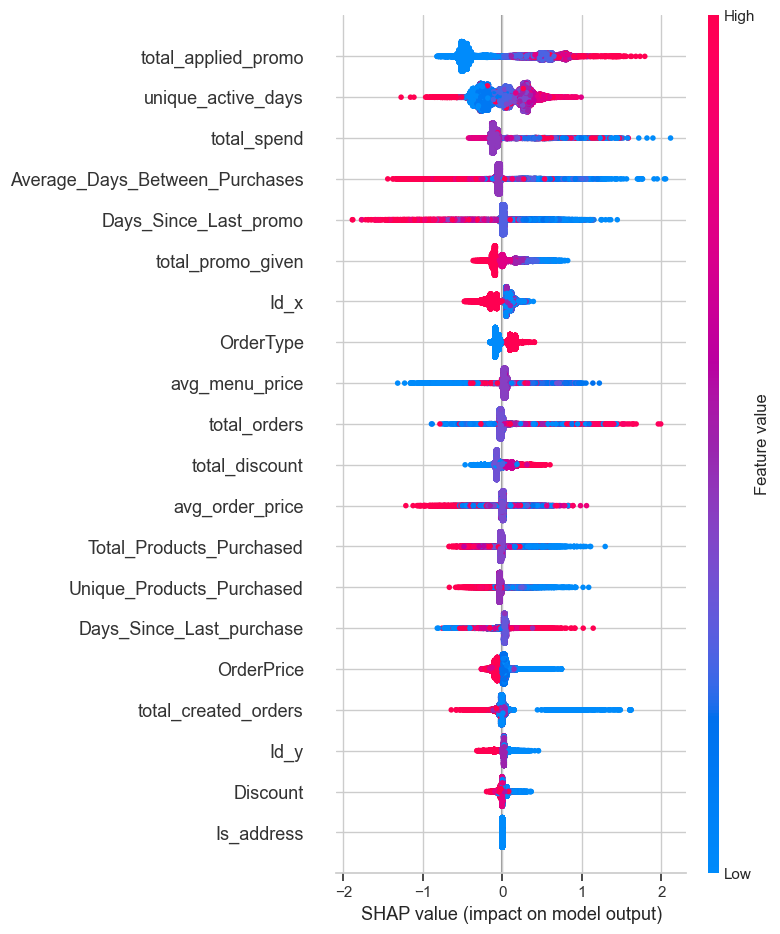

In [124]:
explainer = shap.Explainer(model, features_train)

shap_values = explainer(features_train)

shap.summary_plot(shap_values, features_train)

# Submission

In [125]:
y_pred_prob = CV_xgb.predict_proba(test)[:, 1] 

In [126]:
sub = pd.DataFrame(y_pred_prob, columns=['apply_promo'])

In [127]:
sub

,apply_promo
0,0.046639
1,0.037619
2,0.020689
3,0.025839
4,0.016129
...,...
6801,0.050428
6802,0.025717
6803,0.024086
6804,0.086398


In [128]:
sub.to_csv('submission.csv', index=False)